<a href="https://colab.research.google.com/github/siaxvii/gnlp-final/blob/main/CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Run
!pip install transformers torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 66.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
#Run
import pandas as pd
import torch
import zipfile
from io import BytesIO
from PIL import Image
from IPython.display import display
from transformers import CLIPProcessor, CLIPModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm

# ---- Step 1: Manual File Uploads ----
print("⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.")

import ipywidgets as widgets

upload_train_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Train CSV')
upload_test_csv = widgets.FileUpload(accept='.csv', multiple=False, description='Upload Test CSV')
upload_zip = widgets.FileUpload(accept='.zip', multiple=False, description='Upload Image ZIP')
display(upload_train_csv, upload_test_csv, upload_zip)


⬆️ Please upload your training CSV, test CSV, and ZIP of images using the upload buttons below.


FileUpload(value={}, accept='.csv', description='Upload Train CSV')

FileUpload(value={}, accept='.csv', description='Upload Test CSV')

FileUpload(value={}, accept='.zip', description='Upload Image ZIP')

In [3]:
#Run
# --- Read CSV ---
def get_dataframe(upload_widget):
    for file in upload_widget.value.values():
        content = file['content']
        return pd.read_csv(BytesIO(content))
    return None

# --- Extract images from zip ---
image_dict = {}

def extract_images(upload_widget):
    print("📦 Extracting images from ZIP (with nested folders)...")
    for file in upload_widget.value.values():
        zf = zipfile.ZipFile(BytesIO(file['content']))
        all_files = zf.namelist()
        print(f"Total files in ZIP: {len(all_files)}")
        for full_path in all_files:
            print("  →", full_path)  # 👈 print every file path


# --- Load CLIP ---
print("📥 Loading CLIP model...")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
print("✅ CLIP model and processor loaded.")


📥 Loading CLIP model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP model and processor loaded.


In [4]:
#Run, upload .zip
from google.colab import files

# Upload training CSV, test CSV, and ZIP of images
uploaded = files.upload()

Saving Images.zip to Images.zip


In [5]:
#Run
def custom_collate(batch):
    texts = [item[0]["input_ids"] for item in batch]
    masks = [item[0]["attention_mask"] for item in batch]
    images = [item[0]["pixel_values"] for item in batch]
    labels = torch.stack([item[1] for item in batch])

    # Pad input_ids and attention_mask
    input_ids = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=processor.tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(masks, batch_first=True, padding_value=0)

    pixel_values = torch.stack(images)

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "pixel_values": pixel_values
    }, labels


In [6]:
#Run
import zipfile
from PIL import Image

image_dict = {}
zip_path = "Images.zip"

with zipfile.ZipFile(zip_path, 'r') as zf:
    for full_path in zf.namelist():
        # Skip junk files from macOS
        if ('__MACOSX' in full_path or '/._' in full_path or full_path.startswith('._')):
            continue

        if full_path.lower().endswith(('.jpg', '.jpeg', '.png')) and not full_path.endswith('/'):
            filename = full_path.split('/')[-1].strip().lower()
            try:
                with zf.open(full_path) as img_file:
                    img = Image.open(img_file).convert("RGB")
                    image_dict[filename] = img
            except Exception as e:
                print(f"❌ Could not load {filename}: {e}")

print(f"✅ Loaded {len(image_dict)} images.")
print("📂 Sample image keys:", list(image_dict.keys())[:5])


✅ Loaded 4869 images.
📂 Sample image keys: ['1.jpg', '10.jpg', '1003.jpg', '1004.jpg', '1006.jpg']


In [63]:
#Run
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from zipfile import ZipFile
from io import BytesIO
from tqdm import tqdm

In [54]:
#Run
class CLIPSentimentClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=3):
        super().__init__()
        self.clip = clip_model
        # for param in self.clip.parameters():
        #     param.requires_grad = False  # freeze CLIP
        for name, param in self.clip.named_parameters():
          if "visual.transformer.resblocks.11" in name or "text_model.encoder.layers.11" in name:
              param.requires_grad = True
          else:
              param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, num_classes)
        )


    def forward(self, inputs):
        text_feat = self.clip.get_text_features(input_ids=inputs["input_ids"],
                                                attention_mask=inputs["attention_mask"])
        text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

        image_feat = self.clip.get_image_features(pixel_values=inputs["pixel_values"])
        image_feat = image_feat / image_feat.norm(p=2, dim=-1, keepdim=True)

        combined = torch.cat([text_feat, image_feat], dim=1)
        return self.classifier(combined)


In [64]:
#Run
class CLIPDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Spanglish Tweet']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


In [56]:
device = "cuda" if torch.cuda.is_available() else "cpu"
#Run
train_df = get_dataframe(upload_train_csv)
test_df = get_dataframe(upload_test_csv)

# Label encoding
label_encoder = LabelEncoder()
label_encoder.fit(train_df['label'])

# Create DataLoader
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")

dataset = CLIPDataset(train_df, processor, label_encoder)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=custom_collate)

# Model
model = CLIPSentimentClassifier(clip_model, num_classes=len(label_encoder.classes_)).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=1e-4)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    torch.cuda.empty_cache()

    print(f"🔥 Epoch {epoch+1} Loss: {total_loss:.4f}")


Epoch 1/20: 100%|██████████| 398/398 [00:37<00:00, 10.72it/s]


🔥 Epoch 1 Loss: 434.8004


Epoch 2/20: 100%|██████████| 398/398 [00:36<00:00, 10.97it/s]


🔥 Epoch 2 Loss: 401.9069


Epoch 3/20: 100%|██████████| 398/398 [00:36<00:00, 10.92it/s]


🔥 Epoch 3 Loss: 355.1411


Epoch 4/20: 100%|██████████| 398/398 [00:36<00:00, 10.87it/s]


🔥 Epoch 4 Loss: 323.1845


Epoch 5/20: 100%|██████████| 398/398 [00:37<00:00, 10.63it/s]


🔥 Epoch 5 Loss: 296.6158


Epoch 6/20: 100%|██████████| 398/398 [00:37<00:00, 10.61it/s]


🔥 Epoch 6 Loss: 275.9577


Epoch 7/20: 100%|██████████| 398/398 [00:36<00:00, 10.78it/s]


🔥 Epoch 7 Loss: 251.9141


Epoch 8/20: 100%|██████████| 398/398 [00:36<00:00, 10.88it/s]


🔥 Epoch 8 Loss: 230.8623


Epoch 9/20: 100%|██████████| 398/398 [00:36<00:00, 10.89it/s]


🔥 Epoch 9 Loss: 210.2651


Epoch 10/20: 100%|██████████| 398/398 [00:36<00:00, 10.83it/s]


🔥 Epoch 10 Loss: 191.6956


Epoch 11/20: 100%|██████████| 398/398 [00:36<00:00, 10.94it/s]


🔥 Epoch 11 Loss: 172.8260


Epoch 12/20: 100%|██████████| 398/398 [00:36<00:00, 10.91it/s]


🔥 Epoch 12 Loss: 152.2497


Epoch 13/20: 100%|██████████| 398/398 [00:37<00:00, 10.51it/s]


🔥 Epoch 13 Loss: 135.5436


Epoch 14/20: 100%|██████████| 398/398 [00:37<00:00, 10.48it/s]


🔥 Epoch 14 Loss: 118.6093


Epoch 15/20: 100%|██████████| 398/398 [00:38<00:00, 10.38it/s]


🔥 Epoch 15 Loss: 99.8695


Epoch 16/20: 100%|██████████| 398/398 [00:37<00:00, 10.59it/s]


🔥 Epoch 16 Loss: 86.5607


Epoch 17/20: 100%|██████████| 398/398 [00:37<00:00, 10.68it/s]


🔥 Epoch 17 Loss: 70.5874


Epoch 18/20: 100%|██████████| 398/398 [00:37<00:00, 10.50it/s]


🔥 Epoch 18 Loss: 57.2634


Epoch 19/20: 100%|██████████| 398/398 [00:38<00:00, 10.41it/s]


🔥 Epoch 19 Loss: 45.8202


Epoch 20/20: 100%|██████████| 398/398 [00:37<00:00, 10.61it/s]

🔥 Epoch 20 Loss: 35.9818


In [57]:
#Run
class CLIPTestDataset(Dataset):
    def __init__(self, dataframe, processor, label_encoder):
        self.df = dataframe
        self.processor = processor
        self.label_encoder = label_encoder
        self.labels = label_encoder.transform(self.df['label'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = row['Spanglish Tweet']
        fname = row['file name']
        image = image_dict.get(fname, Image.new("RGB", (224, 224), color='white'))

        inputs = self.processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        label = torch.tensor(self.labels[idx])
        return inputs, label


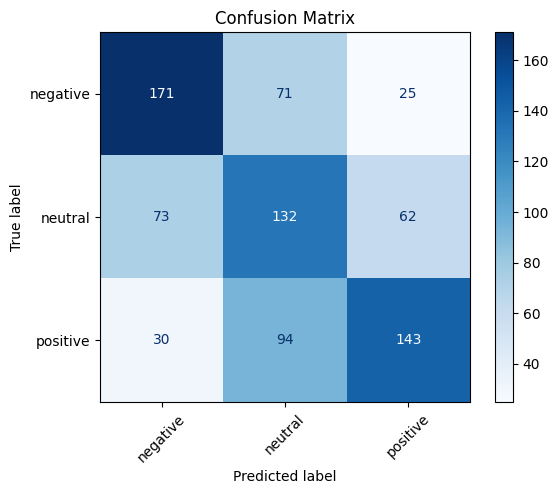

In [59]:
#Run
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [58]:
#Run
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Setup
test_df['file name'] = test_df['file name'].str.strip().str.lower()
test_df['label'] = test_df['label'].str.strip().str.lower()

test_dataset = CLIPTestDataset(test_df, processor, label_encoder)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=custom_collate)

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating"):
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        outputs = model(inputs)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to original label names
y_true = label_encoder.inverse_transform(all_labels)
y_pred = label_encoder.inverse_transform(all_preds)

# Show metrics
print("✅ Evaluation Complete\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, digits=3))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("F1 Macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 Weighted:", f1_score(y_true, y_pred, average='weighted'))


Evaluating: 100%|██████████| 51/51 [00:08<00:00,  5.76it/s]

✅ Evaluation Complete

              precision    recall  f1-score   support

    negative      0.624     0.640     0.632       267
     neutral      0.444     0.494     0.468       267
    positive      0.622     0.536     0.575       267

    accuracy                          0.557       801
   macro avg      0.563     0.557     0.559       801
weighted avg      0.563     0.557     0.559       801

Accuracy: 0.5568039950062422
F1 Macro: 0.5585668281394295
F1 Weighted: 0.5585668281394295


In [74]:
# --- ZERO-SHOT EVALUATION ---

from torch.nn.functional import cosine_similarity

# Define the candidate class prompts
class_names = ['negative', 'neutral', 'positive']
class_prompts = [f"This is a {label} tweet." for label in class_names]

def zero_shot_classify(text, image):
    text = text[:200]  # quick fix for long tweets that may overflow CLIP (77 tokens ~= ~200 characters for English/Spanglish)

    # Prepare class prompts
    class_names = ['negative', 'neutral', 'positive']
    class_prompts = [f"This is a {label} tweet." for label in class_names]

    # Get class embeddings
    inputs = processor(text=class_prompts, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        class_embeddings = model.clip.get_text_features(**inputs)
        class_embeddings = class_embeddings / class_embeddings.norm(p=2, dim=-1, keepdim=True)

    # Get tweet + image features
    pair_inputs = processor(text=[text], images=image, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        image_feat = model.clip.get_image_features(pixel_values=pair_inputs["pixel_values"])
        text_feat = model.clip.get_text_features(input_ids=pair_inputs["input_ids"], attention_mask=pair_inputs["attention_mask"])

        image_feat = image_feat / image_feat.norm(p=2, dim=-1, keepdim=True)
        text_feat = text_feat / text_feat.norm(p=2, dim=-1, keepdim=True)

        combined_feat = (image_feat + text_feat)

    # Compare to class embeddings
    sims = cosine_similarity(combined_feat, class_embeddings)
    pred_idx = sims.argmax().item()
    return class_names[pred_idx], sims.squeeze().tolist()


# Run zero-shot on the test set
test_results = []

for i, row in tqdm(test_df.iterrows(), total=len(test_df)):
    tweet = row['Original English']
    fname = row['file name']
    image = image_dict.get(fname.lower().strip())

    if image is None:
        print(f"❌ Image not found: {fname}")
        continue

    pred_label, scores = zero_shot_classify(tweet, image)
    test_results.append({
        "file name": fname,
        "tweet": tweet,
        "predicted": pred_label,
        "scores": scores,
        "true": row["label"]
    })

# Create DataFrame with predictions
zero_shot_df = pd.DataFrame(test_results)
print(zero_shot_df.head())

# Optional: Classification report
print("\n📊 Zero-shot classification report:")
print(classification_report(zero_shot_df["true"], zero_shot_df["predicted"]))


100%|██████████| 801/801 [00:25<00:00, 30.89it/s]

  file name                                              tweet predicted  \
0  4237.jpg  RT @PeggyMcAloon: Children learn by watching t...   neutral   
1  4238.jpg  .@camcitco @Cambridge_Uni Cambridge must rejec...  positive   
2  4240.jpg  RT @FinleyFootprint: @MissDonnaMcC Please RT? ...  positive   
3  4242.jpg  The barbarity of vivisection can never be part...  positive   
4  4243.jpg  After 20 years. Ups and downs but I do have a ...  positive   

                                              scores      true  
0  [0.576251208782196, 0.5892317891120911, 0.5880...  positive  
1  [0.5527288317680359, 0.5446208715438843, 0.555...  positive  
2  [0.5605205297470093, 0.566272497177124, 0.5707...  positive  
3  [0.4877277612686157, 0.4834960103034973, 0.493...  positive  
4  [0.6497218012809753, 0.6523152589797974, 0.666...  positive  

📊 Zero-shot classification report:
              precision    recall  f1-score   support

    negative       0.37      0.16      0.23       267
     neu

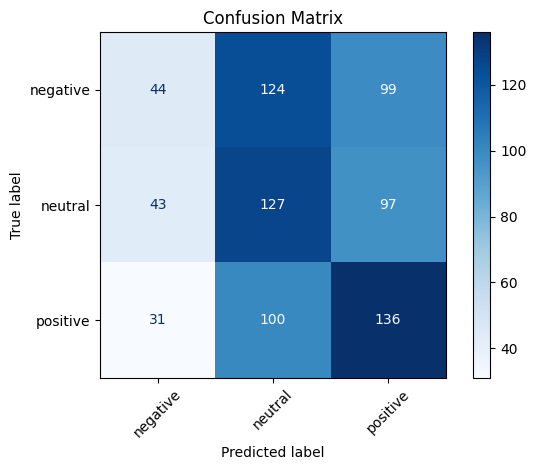

In [75]:
# Create the confusion matrix
y_true = zero_shot_df["true"]
y_pred = zero_shot_df["predicted"]

cm = confusion_matrix(y_true, y_pred, labels=class_names)

# Plot the confusion matrix using seaborn
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.show()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()




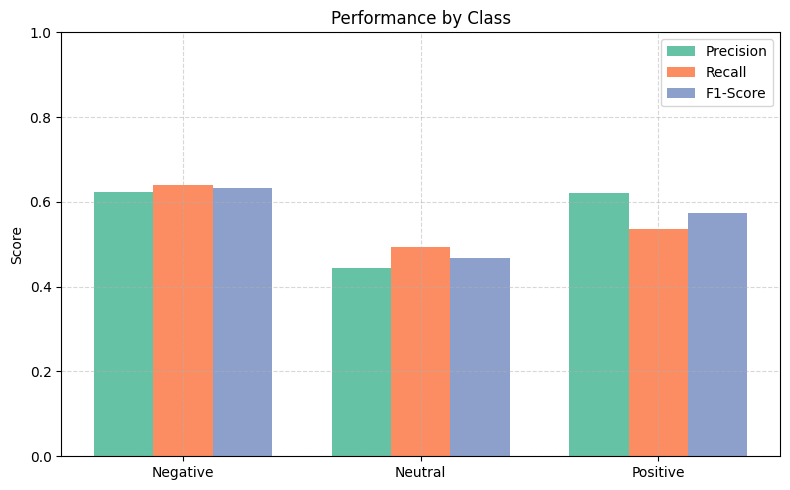

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Your values
labels = ['Negative', 'Neutral', 'Positive']
precision = [0.624, 0.444, 0.622]
recall = [0.640, 0.494, 0.536]
f1_score = [0.632, 0.468, 0.575]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#66c2a5')
bars2 = ax.bar(x, recall, width, label='Recall', color='#fc8d62')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#8da0cb')

ax.set_ylabel('Score')
ax.set_title('Performance by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


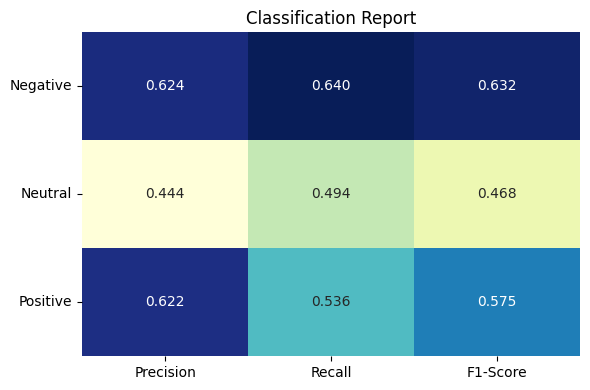

In [61]:
import seaborn as sns
import pandas as pd

# Create DataFrame
data = {
    "Precision": [0.624, 0.444, 0.622],
    "Recall": [0.640, 0.494, 0.536],
    "F1-Score": [0.632, 0.468, 0.575]
}
df = pd.DataFrame(data, index=["Negative", "Neutral", "Positive"])

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".3f", cbar=False)
plt.title("Classification Report")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
